In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


-----------------------

***Install Requirement Packages***

In [2]:
!pip install -q transformers
!pip install -q hazm
!pip install -q PersianStemmer
!pip install -q loading

     |████████████████████████████████| 4.7 MB 20.1 MB/s 
     |████████████████████████████████| 6.6 MB 64.6 MB/s 
     |████████████████████████████████| 596 kB 64.6 MB/s 
     |████████████████████████████████| 101 kB 8.6 MB/s 
     |████████████████████████████████| 316 kB 34.8 MB/s 
     |████████████████████████████████| 1.4 MB 61.2 MB/s 
     |████████████████████████████████| 233 kB 65.2 MB/s 
     |████████████████████████████████| 810 kB 33.1 MB/s 


--------------------------

In [3]:
import pandas as pd
import numpy as np
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_fscore_support

from hazm import *

import matplotlib.pyplot as plt

import os

from tqdm.notebook import tqdm

from PersianStemmer import PersianStemmer

from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoConfig, AutoModel, BertConfig, BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments

from typing import List, Mapping, Tuple
import loading
import collections


In [4]:
def set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).

    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
    if is_tf_available():
        import tensorflow as tf

        tf.random.set_seed(seed)

set_seed(0)

***Load and Preprocessing Data***

In [5]:
file_open = open('/content/gdrive/MyDrive/NLP - HW5/persica.csv')
file = file_open.readlines()
file_open.close()
for i in range(len(file)):
    file[i] =  file[i].replace('\n','')
    file[i] =  file[i].replace(',','')

In [6]:
category = []
news_subcategory = []
news_title = []
news_text = []
news_id = []
for i in range(0,len(file),7):
    news_id.append(file[i].replace('\ufeff',''))
    news_title.append(file[i+1])
    news_text.append(file[i+2])
    news_subcategory.append(file[i+5][:-1])
    category.append(file[i+6])

In [7]:
for subject in set(category):
    print(f'Count of news in subject {subject} = {list.count(category,subject)}')

Count of news in subject فرهنگي = 1000
Count of news in subject مذهبي = 1000
Count of news in subject بهداشتي = 1000
Count of news in subject اقتصادي = 1000
Count of news in subject آموزشي = 1000
Count of news in subject اجتماعي = 1000
Count of news in subject سياسي = 1000
Count of news in subject ورزشي = 1000
Count of news in subject فقه و حقوق = 1000
Count of news in subject علمي = 1000
Count of news in subject تاريخي = 999


In [8]:
d = {'news_id': news_id, 'news_title': news_title, 'news_text': news_text, 'news_subcategory': news_subcategory , 'news_category': category}
df = pd.DataFrame(data=d)
df.head()

,news_id,news_title,news_text,news_subcategory,news_category
0,843656,وزير علوم درجمع استادان نمونه: سن بازنشستگي اس...,وزير علوم در جمع استادان نمونه كشور گفت: از اس...,آموزشي,آموزشي
1,837144,گردهمايي دانش‌آموختگان موسسه آموزش عالي سوره ب...,به گزارش سرويس صنفي آموزشي خبرگزاري دانشجويان ...,آموزشي,آموزشي
2,436862,نتايج آزمون دوره‌هاي فراگير دانشگاه پيام‌نور ا...,نتايج آزمون دوره‌هاي فراگير مقاطع كارشناسي و ك...,آموزشي,آموزشي
3,227781,همايش يكروزه آسيب شناسي مفهوم روابط عمومي در ب...,,اجتماعي-خانواده,اجتماعي
4,174187,وضعيت اقتصادي و ميزان تحصيلات والدين از مهمتري...,محمدتقي علوي يزدي، مجري اين طرح پژوهشي در اين‌...,آموزشي,آموزشي


In [9]:
le = LabelEncoder()
le.fit(list(set(category)))
df['category'] = le.transform(df['news_category'])
df.head()

,news_id,news_title,news_text,news_subcategory,news_category,category
0,843656,وزير علوم درجمع استادان نمونه: سن بازنشستگي اس...,وزير علوم در جمع استادان نمونه كشور گفت: از اس...,آموزشي,آموزشي,0
1,837144,گردهمايي دانش‌آموختگان موسسه آموزش عالي سوره ب...,به گزارش سرويس صنفي آموزشي خبرگزاري دانشجويان ...,آموزشي,آموزشي,0
2,436862,نتايج آزمون دوره‌هاي فراگير دانشگاه پيام‌نور ا...,نتايج آزمون دوره‌هاي فراگير مقاطع كارشناسي و ك...,آموزشي,آموزشي,0
3,227781,همايش يكروزه آسيب شناسي مفهوم روابط عمومي در ب...,,اجتماعي-خانواده,اجتماعي,1
4,174187,وضعيت اقتصادي و ميزان تحصيلات والدين از مهمتري...,محمدتقي علوي يزدي، مجري اين طرح پژوهشي در اين‌...,آموزشي,آموزشي,0


In [10]:
# create a key finder based on label 2 id and id to label

label2id = {label: i for i, label in enumerate(le.classes_)}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

label2id: {'آموزشي': 0, 'اجتماعي': 1, 'اقتصادي': 2, 'بهداشتي': 3, 'تاريخي': 4, 'سياسي': 5, 'علمي': 6, 'فرهنگي': 7, 'فقه و حقوق': 8, 'مذهبي': 9, 'ورزشي': 10}
id2label: {0: 'آموزشي', 1: 'اجتماعي', 2: 'اقتصادي', 3: 'بهداشتي', 4: 'تاريخي', 5: 'سياسي', 6: 'علمي', 7: 'فرهنگي', 8: 'فقه و حقوق', 9: 'مذهبي', 10: 'ورزشي'}


In [11]:
for cls, ind in label2id.items():
    print(f'The number corresponding to the {cls} is:  \t {ind}')

The number corresponding to the آموزشي is:  	 0
The number corresponding to the اجتماعي is:  	 1
The number corresponding to the اقتصادي is:  	 2
The number corresponding to the بهداشتي is:  	 3
The number corresponding to the تاريخي is:  	 4
The number corresponding to the سياسي is:  	 5
The number corresponding to the علمي is:  	 6
The number corresponding to the فرهنگي is:  	 7
The number corresponding to the فقه و حقوق is:  	 8
The number corresponding to the مذهبي is:  	 9
The number corresponding to the ورزشي is:  	 10


In [12]:
df['news_category'].value_counts()

آموزشي        1000
اجتماعي       1000
اقتصادي       1000
بهداشتي       1000
علمي          1000
سياسي         1000
فرهنگي        1000
فقه و حقوق    1000
مذهبي         1000
ورزشي         1000
تاريخي         999
Name: news_category, dtype: int64

In [13]:
df['news_text'].apply(
    lambda s: len(s.split())).describe()

count    10999.000000
mean       412.191836
std        590.737729
min          0.000000
25%        140.000000
50%        241.000000
75%        417.500000
max       6332.000000
Name: news_text, dtype: float64

***These statistics show that the max length of the news_test is 6332 words. but we should set a limit for bert model. we consider 512 words for input.***

In [14]:
# print data information
print('data information')
print(df.info(), '\n')

# print missing values information
print('missing values stats')
print(df.isnull().sum())

data information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   news_id           10999 non-null  object
 1   news_title        10999 non-null  object
 2   news_text         10999 non-null  object
 3   news_subcategory  10999 non-null  object
 4   news_category     10999 non-null  object
 5   category          10999 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 515.7+ KB
None 

missing values stats
news_id             0
news_title          0
news_text           0
news_subcategory    0
news_category       0
category            0
dtype: int64


In [15]:
df = df.drop_duplicates(subset=['news_text'], keep='first')
df = df.reset_index(drop=True)

In [16]:
X_train,X_test,y_train,y_test = train_test_split(df['news_text'],df['category'],test_size=0.2,random_state=0,shuffle=True)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.1,random_state=0,shuffle=True)

X_train = X_train.values.tolist()
y_train = y_train.values.tolist()

X_val = X_val.values.tolist()
y_val = y_val.values.tolist()

X_test = X_test.values.tolist()
y_test = y_test.values.tolist()

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device: cuda:0
CUDA is available!  Training on GPU ...


In [18]:
model_name = "HooshvareLab/bert-fa-base-uncased"
Output_Path = '/content/gdrive/MyDrive/NLP - HW5/pytorch_model1.bin'
# max sequence length for each document/sentence sample
max_length = 512

In [19]:
# load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained(model_name)
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=max_length)

In [20]:
class PersicaDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)


In [21]:
# convert our tokenized data into a torch Dataset
train_dataset = PersicaDataset(train_encodings, y_train)
valid_dataset = PersicaDataset(valid_encodings, y_val)

In [22]:
# load the model and pass to CUDA
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(list(label2id.keys()))).to("cuda")

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

In [23]:
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

In [24]:
training_args = TrainingArguments(
    output_dir='/content/gdrive/MyDrive/NLP - HW5/results',          # output directory
    num_train_epochs=4,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=200,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='/content/gdrive/MyDrive/NLP - HW5/logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=1000,               # log & save weights each logging_steps
    save_steps=1000,
    evaluation_strategy="steps",     # evaluate each `logging_steps`
)

In [25]:
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

In [26]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 7857
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3932


Step,Training Loss,Validation Loss,Accuracy
1000,0.828200,0.522115,0.865979
2000,0.390700,0.522856,0.879725
3000,0.216700,0.550005,0.902635


***** Running Evaluation *****
  Num examples = 873
  Batch size = 20
Saving model checkpoint to /content/gdrive/MyDrive/NLP - HW5/results/checkpoint-1000
Configuration saved in /content/gdrive/MyDrive/NLP - HW5/results/checkpoint-1000/config.json
Model weights saved in /content/gdrive/MyDrive/NLP - HW5/results/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 873
  Batch size = 20
Saving model checkpoint to /content/gdrive/MyDrive/NLP - HW5/results/checkpoint-2000
Configuration saved in /content/gdrive/MyDrive/NLP - HW5/results/checkpoint-2000/config.json
Model weights saved in /content/gdrive/MyDrive/NLP - HW5/results/checkpoint-2000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 873
  Batch size = 20
Saving model checkpoint to /content/gdrive/MyDrive/NLP - HW5/results/checkpoint-3000
Configuration saved in /content/gdrive/MyDrive/NLP - HW5/results/checkpoint-3000/config.json
Model weights saved in /content/gdrive/MyDrive/NLP - HW5/r

TrainOutput(global_step=3932, training_loss=0.3893737094448396, metrics={'train_runtime': 3393.2376, 'train_samples_per_second': 9.262, 'train_steps_per_second': 1.159, 'total_flos': 8269722448367616.0, 'train_loss': 0.3893737094448396, 'epoch': 4.0})

In [27]:
def get_prediction(text):
    # prepare our text into tokenized sequence
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
    # perform inference to our model
    outputs = model(**inputs)
    # get output probabilities by doing softmax
    probs = outputs[0].softmax(1)
    # executing argmax function to get the candidate label
    return list(label2id.keys())[probs.argmax()]

In [28]:
y_pred = []
for x in X_test:
  y_pred.append(get_prediction(x))
y_pred = [label2id[x] for x in y_pred]

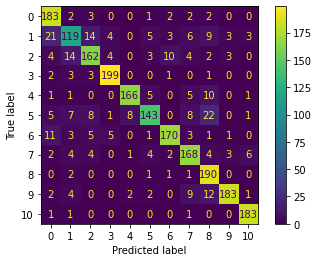

In [29]:
cm = confusion_matrix(y_true = y_test, y_pred= y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(label2id.values()))
disp.plot()
plt.show()

In [30]:
accuracy_score(y_test, y_pred)

0.8547869903802107

In [31]:
classes = [str(x) for x in label2id.values()]
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

           0       0.79      0.94      0.86       195
           1       0.74      0.64      0.69       187
           2       0.81      0.79      0.80       206
           3       0.93      0.95      0.94       209
           4       0.94      0.88      0.91       189
           5       0.87      0.70      0.78       203
           6       0.90      0.85      0.87       200
           7       0.81      0.85      0.83       198
           8       0.75      0.97      0.85       195
           9       0.95      0.85      0.90       215
          10       0.94      0.98      0.96       186

    accuracy                           0.85      2183
   macro avg       0.86      0.85      0.85      2183
weighted avg       0.86      0.85      0.85      2183

